# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import spearmanr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

# Load and Explore Datasets
Load `rfq.csv` and `reference_properties.tsv`.  
Inspect 5 first rows, data types, shape, missing values, and duplicates.

In [2]:
rfq = pd.read_csv("../resources/task_2/rfq.csv")
ref = pd.read_csv("../resources/task_2/reference_properties.tsv", sep="\t")

In [3]:
# Look at 5 first rows
ref.head()

,Grade/Material,UNS_No,Steel_No,Standards,Carbon (C),Manganese (Mn),Silicon (Si),Sulfur (S),Phosphorus (P),Chromium (Cr),...,Reduction of area (Z%),"Hardness (HB, HV, HRC)",Impact toughness (Charpy V-notch),Fatigue limit,Creep resistance,Source_Pages,Application,Category,Nb + V + Ti (Others),Coating
0,S235JR,NaN,NaN,EN 10025-2:2019,≤0.17,≤1.40,≤0.40,≤0.035,≤0.035,NaN,...,NaN,NaN,27J at 20°C,NaN,NaN,Standard Specifications,General structural steels,Structural Steel,NaN,NaN
1,S275JR,NaN,NaN,EN 10025-2:2019,≤0.21,≤1.50,≤0.40,≤0.035,≤0.035,NaN,...,NaN,NaN,27J at 20°C,NaN,NaN,Standard Specifications,General structural steels,Structural Steel,NaN,NaN
2,S355JR,NaN,NaN,EN 10025-2:2019,≤0.24,≤1.60,≤0.55,≤0.035,≤0.035,NaN,...,NaN,NaN,27J at 20°C,NaN,NaN,Standard Specifications,General structural steels,Structural Steel,NaN,NaN
3,S420M,NaN,NaN,EN 10025-3:2019,≤0.20,1.00-1.70,≤0.50,≤0.025,≤0.030,≤0.30,...,NaN,NaN,27J at -20°C,NaN,NaN,Standard Specifications,Thermomechanically rolled steels,High Strength Steel,NaN,NaN
4,S460M,NaN,NaN,EN 10025-3:2019,≤0.20,1.00-1.70,≤0.50,≤0.025,≤0.030,≤0.30,...,NaN,NaN,27J at -20°C,NaN,NaN,Standard Specifications,Thermomechanically rolled steels,High Strength Steel,NaN,NaN


In [4]:
ref.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Grade/Material                     175 non-null    object 
 1   UNS_No                             0 non-null      float64
 2   Steel_No                           0 non-null      float64
 3   Standards                          175 non-null    object 
 4   Carbon (C)                         175 non-null    object 
 5   Manganese (Mn)                     175 non-null    object 
 6   Silicon (Si)                       134 non-null    object 
 7   Sulfur (S)                         163 non-null    object 
 8   Phosphorus (P)                     163 non-null    object 
 9   Chromium (Cr)                      42 non-null     object 
 10  Nickel (Ni)                        16 non-null     object 
 11  Molybdenum (Mo)                    30 non-null     object 

In [5]:
ref.shape

(175, 34)

In [6]:
# Look for duplicates
len(ref[ref["Grade/Material"].duplicated()])

0

In [7]:
ref.isna().sum()

Grade/Material                         0
UNS_No                               175
Steel_No                             175
Standards                              0
Carbon (C)                             0
Manganese (Mn)                         0
Silicon (Si)                          41
Sulfur (S)                            12
Phosphorus (P)                        12
Chromium (Cr)                        133
Nickel (Ni)                          159
Molybdenum (Mo)                      145
Vanadium (V)                         150
Tungsten (W)                         175
Cobalt (Co)                          175
Copper (Cu)                          174
Aluminum (Al)                         81
Titanium (Ti)                        146
Niobium (Nb)                         149
Boron (B)                            167
Nitrogen (N)                         158
Tensile strength (Rm)                  0
Yield strength (Re or Rp0.2)          11
Elongation (A%)                       21
Reduction of are

## Missing Data: 

Currently, both `UNS_No` and `Steel_No` are fully missing in the dataset.  
However, it is possible to impute this information using cross-references for steel grades.

### Possible Approaches
- Scrape reference websites that map steel grades to UNS/Steel numbers. (I created cross_refrence_builder notebook for this purpose)
- Use an existing open dataset as a lookup table.  
- A prototype scraper function was tested, but the results were not fully reliable, so it was left as-is for now.  

This can be improved later by refining the scraper or switching to a more robust dataset.

In [8]:
# Look at 5 first rows
rfq.head()

,id,grade,grade_suffix,coating,finish,surface_type,surface_protection,form,thickness_min,thickness_max,...,weight_min,weight_max,inner_diameter_min,inner_diameter_max,outer_diameter_min,outer_diameter_max,yield_strength_min,yield_strength_max,tensile_strength_min,tensile_strength_max
0,8aff426d-b8c0-43aa-ad26-835ef4de6129,S700MC,NaN,NaN,Oiled,NaN,NaN,Coils,6.0,6.0,...,15000.0,25000.0,610.0,610.0,NaN,NaN,NaN,NaN,760.0,810.0
1,37e624be-b125-464f-85b6-1838530193ef,S250GD,NaN,ZM310,Hot-dip zinc magnesium (+ZM),NaN,NaN,Slit Coils,1.5,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,b8257184-6307-46ab-b06e-d979336d1263,DX51D,NaN,Z100,Hot-dip Galvanized (+Z/+GI),NaN,Lightly Oiled (L),Coils,0.4,0.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,63140d1f-dda8-40fe-8931-bcaba65d5772,S235,NaN,NaN,NaN,NaN,NaN,Round Tubes,1.5,1.5,...,53800.0,53800.0,NaN,NaN,60.3,NaN,NaN,NaN,NaN,NaN
4,11cffc57-44be-4d79-bfd5-97482be566d3,S235,NaN,NaN,NaN,NaN,NaN,Round Tubes,1.5,1.5,...,14500.0,14500.0,NaN,NaN,48.3,NaN,NaN,NaN,NaN,NaN


In [9]:
rfq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1000 non-null   object 
 1   grade                 941 non-null    object 
 2   grade_suffix          0 non-null      float64
 3   coating               318 non-null    object 
 4   finish                665 non-null    object 
 5   surface_type          135 non-null    object 
 6   surface_protection    287 non-null    object 
 7   form                  927 non-null    object 
 8   thickness_min         833 non-null    float64
 9   thickness_max         834 non-null    float64
 10  width_min             539 non-null    float64
 11  width_max             652 non-null    float64
 12  length_min            131 non-null    float64
 13  height_min            132 non-null    float64
 14  height_max            2 non-null      float64
 15  weight_min            

In [10]:
rfq.shape

(1000, 25)

In [11]:
rfq.isna().sum()

id                         0
grade                     59
grade_suffix            1000
coating                  682
finish                   335
surface_type             865
surface_protection       713
form                      73
thickness_min            167
thickness_max            166
width_min                461
width_max                348
length_min               869
height_min               868
height_max               998
weight_min               607
weight_max               369
inner_diameter_min       823
inner_diameter_max       822
outer_diameter_min       977
outer_diameter_max       980
yield_strength_min       964
yield_strength_max       984
tensile_strength_min     951
tensile_strength_max     949
dtype: int64

# Handling Missing Data

- The `grade_suffix` column is completely missing, but we can extract it from the `grade` column.  
- The `grade` column has 59 missing values. We can assume these represent cases where there was no strong opinion about the grade and fill them as `"UNKNOWN"`.  
- We can also explore the dataset for duplicated rows **without grade and ID**. If two rows match exactly except for `id` and `grade`, we can assume they are duplicates and use the available grade to fill the missing one.  
- Some information, such as `tensile` and `yield`, can be imputed using reference data.  
- For categorical features in general, missing values can be filled with `"UNKNOWN"`.

# Column Names

To maintain consistency across both datasets, all column names should be lowercase and free of whitespace or special characters.

In [12]:
def clean_column(name: str) -> str:
    # Lowercase
    name = name.lower()
    if "(" in name and ")" in name:
        start = name.index("(")
        end = name.index(")")
        name = (name[:start] + name[end+1:]).strip()
    # Replace common separators with underscore
    for ch in [" ", "/", "-", ".", "+"]:
        name = name.replace(ch, "_")
    # Remove double underscores
    while "__" in name:
        name = name.replace("__", "_")
    # Strip underscores at ends
    name = name.strip("_")
    return name

In [13]:
ref.columns = [clean_column(c) for c in ref.columns]
ref.rename(columns={"grade_material": "grade"}, inplace=True) # Keep consistency

rfq.columns = [clean_column(c) for c in rfq.columns]

# Grade

In [14]:
def normalize_grade(grade: str):
    # Uppercase and remove spaces
    grade_norm = str(grade).upper().replace(" ", "")
    return grade_norm

In [15]:
rfq.loc[rfq["grade"].notna(), "grade"] = rfq.loc[rfq["grade"].notna(), "grade"].apply(normalize_grade)
ref["grade"] = ref["grade"].apply(normalize_grade)

After uppercasing all grades, it's time to revisit the reference data and identify any potential duplicates.

In [16]:
ref[ref.grade.duplicated(keep=False)]

,grade,uns_no,steel_no,standards,carbon,manganese,silicon,sulfur,phosphorus,chromium,...,reduction_of_area,hardness,impact_toughness,fatigue_limit,creep_resistance,source_pages,application,category,nb_v_ti,coating
57,26MNB5,NaN,NaN,Automotive specification,0.23-0.29,1.10-1.40,0.15-0.35,≤0.010,≤0.025,0.14-0.26,...,NaN,42-49 HRC,NaN,NaN,NaN,Standard Specifications,Press hardening steel for automotive,Press Hardening Steel,NaN,NaN
58,26MNB5,NaN,NaN,Automotive specification,0.23-0.29,1.10-1.40,0.15-0.35,≤0.010,≤0.025,0.14-0.26,...,NaN,42-49 HRC,NaN,NaN,NaN,Standard Specifications,Press hardening steel for automotive,Press Hardening Steel,NaN,NaN
137,HC380LA,NaN,NaN,Automotive specification,≤0.12,0.70-1.40,≤0.50,≤0.015,≤0.025,NaN,...,NaN,NaN,NaN,NaN,NaN,Standard Specifications,Automotive high strength low alloy,HSLA Steel,NaN,NaN
138,HC380LA,NaN,NaN,Automotive specification,≤0.12,0.70-1.40,≤0.50,≤0.015,≤0.025,NaN,...,NaN,NaN,NaN,NaN,NaN,Standard Specifications,Automotive high strength low alloy (variant),HSLA Steel,NaN,NaN


In [17]:
ref = ref.drop_duplicates(subset=["grade"]).reset_index(drop=True)

Now, we check the unique values of both datasets to ensure that all `rfq-grade` information is present in the reference data.

In [18]:
# Check all rfq grade exist in ref
rfq_grade_list =  list(rfq.grade.unique())
ref_grade_list =  list(ref.grade.unique())
missing = [item for item in rfq_grade_list if item not in ref_grade_list]
missing

[nan]

The only missing values are in the `rfq` dataset; the reference dataset has no missing values.

## Apply Uppercase to All Values for Consistency

In [19]:
# Rfq
# Exclude id column
rfq_categorical_columns = rfq.select_dtypes(include="object").drop(columns=["id"]).columns
rfq[rfq_categorical_columns] = rfq[rfq_categorical_columns].apply(lambda x: x.str.upper())

# Ref
ref_categorical_columns = ref.select_dtypes(include="object").columns
ref[ref_categorical_columns] = ref[ref_categorical_columns].apply(lambda x: x.str.upper())

# Finish

In [20]:
rfq.finish.unique()

array(['OILED', 'HOT-DIP ZINC MAGNESIUM (+ZM)',
       'HOT-DIP GALVANIZED (+Z/+GI)', nan, 'GALVANIZED',
       'ELECTRO-GALVANIZED (+ZE)', 'BLACK (S1)', 'SUPERVITAC (SVA)',
       'NORMALIZED (+N)', 'JVD GALVANIZED (+ZV)', 'HOT ROLLED',
       'PREPAINTED (PPGI)', 'COLD ROLLED', '+N', 'ALUMINIZED (+AS/+AL)',
       'ALUZINC (+AZ)', 'COLD ROLLED (+CR)', 'HOT-DIP GALVANIZED (+Z)',
       'STAINED', 'SEAMLESS', 'GALVANNEALED (+ZF)', 'DRY', '1U',
       'AS ROLLED (+AR)', 'QUENCHED AND TEMPERED (+QT)',
       'HOT-DIP ALUZINC (+AZ)',
       'SOFT ANNEALED (+A), AS ROLLED AND TURNED (+SH)', 'ORGANIC (+OC)',
       'SLIGHTLY OILED', 'HOT-DIP GALVANIZED (+GI)', '+HR', '+A',
       'LIGHTLY OILED (L)', 'GALVANNEALED (+ZF/+GA)', 'OILED (O)',
       '+AR PICKLED', 'NK', '+AR', 'LIGHTLY OILED', 'BRIGHT',
       'UNTREATED (+U)', 'FORGED', 'GALVANNEALED',
       'THERMOMECHANICALLY ROLLED (+M)', 'ASTM NO. 2B', 'ASTM NO. 2D',
       'GALFAN (+ZA)'], dtype=object)

As we can see, some `finish` values are repeated in different forms. We need to standardize them to ensure consistency.

In [21]:
finish_dict = {
    "+AR": "AS ROLLED (+AR)",
    "OILED": "OILED (O)",
    "LIGHTLY OILED": "LIGHTLY OILED (L)",
    "+N": "NORMALIZED (+N)",
    "COLD ROLLED": "COLD ROLLED (+CR)",
    "+A": "SOFT ANNEALED (+A)"
}
rfq["finish"] = rfq["finish"].apply(lambda x: finish_dict.get(x, x))

# Suffix

Based on the `grade`, we can extract the suffix (`+` or `-`) and then derive additional information from it.

In [22]:
def suffix_finder(grade):
    # Initialize suffix
    grade_suffix = None
    # Look for suffix starting with '+' or '-'
    for i, c in enumerate(str(grade)):
        if c in "+-":
            grade_suffix = grade[i:]
            break
    if (grade_suffix is not None) and (len(grade_suffix) > 4): 
        return None
    return grade_suffix

In [23]:
rfq["grade_suffix"] = rfq["grade"].apply(suffix_finder)
rfq["grade_suffix"].unique()

array([None, '+N', '+C', '+QT', '-DP'], dtype=object)

Now, we can use these suffixes and their corresponding matches from the reference website to impute missing information.

In [24]:
suffix_finish = {"+N": "Normalized (+N)",
 "+C": "Cold Drawn (+C)",
 "QT": "Quenched and Tempered (+QT)"}
rfq.loc[rfq["finish"].isna(), "finish"] = rfq[rfq["finish"].isna()]["grade_suffix"].apply(lambda x: suffix_finish.get(x, x))

# Other columns

**`surface_protection` → `finish` for RFQ**  
It is possible to extract some information from this column and impute it into other columns.

**`application_ref` → `finish`**  
This column contains a lot of useful information. We could potentially use NLP techniques to automate the extraction, but for now, we will leave it as is.


In [25]:
# rfq.surface_protection.unique()

In [26]:
# ref.application.unique()

In [27]:
# rfq.coating.unique()

For now, we will focus on other tasks, but there are several ways to impute missing values and extract information from these columns.

# Parse Range

Parse simple range strings into `(min, max)`, ignoring units.

**Examples:**  
- `"5-10 kg"`  → `(5.0, 10.0)`  
- `">=7 m"`    → `(7.0, None)`  
- `"≤3.5 cm"`  → `(0.0, 3.5)`  
- `">10%"`     → `(10.0, 100.0)`  
- `"<20%"`     → `(0.0, 20.0)`  
- `"35"`       → `(35.0, 35.0)`  

In [28]:
def parse_range(s: str):
    if s is None or str(s).strip() == "":
        return None, None

    s = str(s).strip()
    allowed = set("0123456789.-≤≥<>% ")
    
    # Remove trailing units (keep only allowed characters)
    i = len(s)
    while i > 0 and s[i-1] not in allowed:
        i -= 1
    s = s[:i].strip()

    # Normalize characters
    s = s.replace("–", "-").replace(" ", "")

    # Range with dash ("5-10")
    if "-" in s and not s.startswith("-"):
        try:
            a, b = map(float, s.split("-", 1))
            return min(a, b), max(a, b)
        except ValueError:
            return None, None

    # Inequalities
    if s.startswith(("≥", ">")):
        if s.endswith("%"):
            try:
                n = float(s[1:-1])
                return n, 100.0
            except ValueError:
                return None, None
        else:
            try:
                n = float(s[1:])
                return n, None
            except ValueError:
                return None, None

    if s.startswith(("≤", "<")):
        if s.endswith("%"):
            try:
                n = float(s[1:-1])
                return 0.0, n
            except ValueError:
                return None, None
        else:
            try:
                n = float(s[1:])
                return 0.0, n
            except ValueError:
                return None, None

    # -Single number
    try:
        n = float(s)
        return n, n
    except ValueError:
        return None, None

In [29]:
def char_finder(df):
    # Look for column with these character
    special_chars = ["-", "≤", "≥", "<", ">", "%"]

    cols_with_special = []

    for col in df.columns:
        if df[col].dtype == "object":  # only check text columns
            # Check if any value in the column contains one of the special characters
            if df[col].astype(str).str.contains("|".join(special_chars), na=False).any():
                cols_with_special.append(col)
    return cols_with_special

In [30]:
cols_with_special = char_finder(ref)
print("Columns containing special characters:", cols_with_special)

Columns containing special characters: ['grade', 'standards', 'carbon', 'manganese', 'silicon', 'sulfur', 'phosphorus', 'chromium', 'nickel', 'molybdenum', 'vanadium', 'copper', 'aluminum', 'titanium', 'niobium', 'boron', 'nitrogen', 'tensile_strength', 'yield_strength', 'elongation', 'hardness', 'impact_toughness', 'application', 'nb_v_ti', 'coating']


## Function for Checking Missing Values

If a column has too many missing values, splitting it into multiple columns can create many `NaN`s, which is inefficient.  
We check the percentage of missing values and make decisions based on that.

In [31]:
# ref[cols_with_special].isna().mean() * 100 

Some columns are not numerical features and may only contain special characters, such as `grade` and `application`, so we exclude them.  
We keep only columns with less than 70% missing values.

In [32]:
import pandas as pd

def parse_columns(df, cols_with_special, threshold=70):
    
    # Compute missing percentage, excluding 'grade' and 'application'
    missing_pct = df[cols_with_special].drop(columns=["grade", "application"], errors='ignore').isna().mean() * 100
    
    # Filter columns below threshold
    cols_below_threshold = missing_pct[missing_pct < threshold].index    
    # Parse ranges and create new columns
    for col in cols_below_threshold:
        df[[f"{col}_min", f"{col}_max"]] = df[col].apply(parse_range).apply(pd.Series)
        df.drop(columns=[col], inplace=True)
    
    return df


In [33]:
ref = parse_columns(ref, char_finder(ref))

# Merge
We left-merge `rfq` with `ref` on `grade`, keeping all `rfq` rows. Suffixes `_rfq` and `_ref` distinguish overlapping columns.

In [34]:
merge_df = rfq.merge(ref, on="grade", how="left", suffixes=("_rfq", "_ref"))

# Handling Tensile and Yield

Both datasets contain `tensile` and `yield` information.  

- If a value exists in `ref` but not in `rfq`, we can fill it from `ref`.  
- When both datasets have values, one approach is to take the **maximum of the min values** and **minimum of the max values**.  

For now, we decide to keep `rfq` values unchanged as much as possible.

In [35]:
# def combine_min_max(min_x, min_y, max_x, max_y):
#     # min: if both exist, take max; else take whichever exists
#     combined_min = pd.Series(np.where(
#         pd.notna(min_x) & pd.notna(min_y),
#         np.maximum(min_x, min_y),
#         min_x.fillna(min_y)
#     ))
#     # max: if both exist, take min; else take whichever exists
#     combined_max = pd.Series(np.where(
#         pd.notna(max_x) & pd.notna(max_y),
#         np.minimum(max_x, max_y),
#         max_x.fillna(max_y)
#     ))
#     return combined_min, combined_max

In [36]:
def fill_rfq_with_ref(df):

    # Loop over columns ending with "_rfq"
    for col in df.columns:
        if col.endswith("_rfq"):
            col_ref = col.replace("_rfq", "_ref")
            if col_ref in df.columns:
                df[col] = df[col].fillna(df[col_ref])
    df = df.drop(columns=[col for col in df.columns if col.endswith("_ref")])
    df = df.rename(columns={col: col.replace("_rfq", "") for col in df.columns if col.endswith("_rfq")})

    return df

In [37]:
merge_df = fill_rfq_with_ref(merge_df)
merge_df.isna().mean() * 100

id                 0.0
grade              5.9
grade_suffix      99.0
coating           66.4
finish            33.1
                  ... 
phosphorus_max     7.1
aluminum_min      46.0
aluminum_max      86.4
elongation_min     7.9
elongation_max     7.9
Length: 63, dtype: float64

In [38]:
def drop_high_missing(df, threshold=0.7):

    missing_ratio = df.isnull().mean()  # proportion of missing values per column
    cols_to_drop = missing_ratio[missing_ratio > threshold].index
    return df.drop(columns=cols_to_drop)


In [39]:
merge_df = drop_high_missing(merge_df, threshold=0.9)

In [40]:
def custom_fillna(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    for col in df.columns:
        if df[col].dtype == "object":  
            # categorical/string
            df[col] = df[col].fillna("UNKNOWN")
        elif col.endswith("_min"):  
            df[col] = df[col].fillna(df[col].min(skipna=True))
        elif col.endswith("_max"):  
            df[col] = df[col].fillna(df[col].max(skipna=True))
        else:  
            # numeric general
            if np.issubdtype(df[col].dtype, np.number):
                df[col] = df[col].fillna(df[col].mean(skipna=True))
    return df

In [41]:
merge_df = custom_fillna(merge_df)
df = merge_df.copy()

# Similarity

## Interval Metrics

For two intervals $A = [a_{\rm min}, a_{\rm max}]$ and $B = [b_{\rm min}, b_{\rm max}]$:

### 1. Intersection over Union (IoU)
$$
\text{IoU}(A, B) = \frac{|A \cap B|}{|A \cup B|}
= \frac{\max(0, \min(a_{\rm max}, b_{\rm max}) - \max(a_{\rm min}, b_{\rm min}))}
       {\max(a_{\rm max}, b_{\rm max}) - \min(a_{\rm min}, b_{\rm min})}
$$

- Fraction of the **combined span** that overlaps.
- Symmetric: $\text{IoU}(A,B) = \text{IoU}(B,A)$
- Range: 0 (no overlap) → 1 (perfect overlap)

### 2. Overlap Ratio (Intersection over Smaller Interval)
$$
\text{Overlap}(A, B) = \frac{|A \cap B|}{\min(|A|, |B|)}
= \frac{\max(0, \min(a_{\rm max}, b_{\rm max}) - \max(a_{\rm min}, b_{\rm min}))}
       {\min(a_{\rm max}-a_{\rm min}, b_{\rm max}-b_{\rm min})}
$$

- Fraction of the **smaller interval** that is covered by the overlap.
- Symmetric: $\text{Overlap}(A,B) = \text{Overlap}(B,A)$
- Range: 0 → 1, where 1 means the smaller interval is fully contained


In [42]:
# Compute similarity matrices
def interval_matrix(mins, maxs, sim_method='iou'):

    n, m = mins.shape
    
    mins_exp = mins[:, np.newaxis, :]  # shape (n,1,m)
    maxs_exp = maxs[:, np.newaxis, :]  # shape (n,1,m)
    
    mins_pair = mins[np.newaxis, :, :]  # shape (1,n,m)
    maxs_pair = maxs[np.newaxis, :, :]  # shape (1,n,m)
    
    # Compute intersection and union
    intersection = np.maximum(0, np.minimum(maxs_exp, maxs_pair) - np.maximum(mins_exp, mins_pair))
    
    if sim_method == "iou":
        union = np.maximum(maxs_exp, maxs_pair) - np.minimum(mins_exp, mins_pair)
        iou = np.divide(intersection, union, out=np.zeros_like(intersection), where=union != 0)
    elif sim_method == "overlap":
        lengths = np.minimum(maxs_exp - mins_exp, maxs_pair - mins_pair)
        iou = np.divide(intersection, lengths, out=np.zeros_like(intersection), where=lengths != 0)
    else:
        raise ValueError("sim_method must be 'iou' or 'overlap'")
    
    # Aggregate across dimensions (average)
    sims = np.nanmean(iou, axis=2)
    
    return sims    # Expand dimensions to (n, 1, m) and (1, n, m) to broadcast pairwise


In [43]:
def dim_similarity(df: pd.DataFrame, sim_method: str="iou"):
    dimension_cols = [
        ("thickness_min", "thickness_max"),
        ("width_min", "width_max"),
        ("length_min", "length_max"),
        ("height_min", "height_max"),
        ("weight_min", "weight_max"),
        ("inner_diameter_min", "inner_diameter_max"),
        ("outer_diameter_min", "outer_diameter_max")
    ]

    existing_dims = []
    for min_col, max_col in dimension_cols:
        if min_col in df.columns:
            if max_col is None or max_col not in df.columns:
                max_col = min_col
            df[min_col] = df[min_col].fillna(df[max_col])
            df[max_col] = df[max_col].fillna(df[min_col])
            existing_dims.append((min_col, max_col))
            
    dim_min = df[[c[0] for c in existing_dims]].to_numpy()
    dim_max = df[[c[1] for c in existing_dims]].to_numpy()

    dim_sims = interval_matrix(dim_min, dim_max, sim_method=sim_method)
    # Remove self matches
    np.fill_diagonal(dim_sims, 0) 

    return dim_sims

In [44]:
def cat_similarity(df, sim_method="partial"):
    categorical_cols = ["coating", "finish", "form", "surface_type"]
    categorical_cols = [c for c in categorical_cols if c in df.columns]
    cat_array = df[categorical_cols].to_numpy(dtype=object) if categorical_cols else None
    cat_array = np.array([tuple(row) for row in cat_array])
    cat_match = cat_array[:, None] == cat_array[None, :]
    # Vectorized pairwise equality
    if sim_method == "partial":
        cat_sims = cat_match.mean(-1).astype(float)  # Mean of all categories that match
    elif sim_method == "exact":
        cat_sims = cat_match.all(-1).astype(int)  # All categories match
    elif sim_method == "jaccard":
        # Vectorized Jaccard for categorical tuples
        # Convert to 2D one-hot encoding per column
        # First, find unique values per column
        n_rows, n_cols = cat_array.shape
        encoded = []
        for c in range(n_cols):
            uniques, inv = np.unique(cat_array[:, c], return_inverse=True)
            one_hot = np.zeros((n_rows, len(uniques)), dtype=bool)
            one_hot[np.arange(n_rows), inv] = True
            encoded.append(one_hot)
        # Concatenate all columns
        encoded = np.hstack(encoded)  # shape: (n_rows, total_unique_categories)
        
        # Compute pairwise intersection and union
        intersection = np.dot(encoded, encoded.T)
        row_sums = encoded.sum(axis=1)
        union = row_sums[:, None] + row_sums[None, :] - intersection
        
        cat_sims = intersection / np.where(union == 0, 1, union)
    else:
        raise ValueError(f"Similarity method {sim_method} is not supported!")
        
    # Remove self matches
    np.fill_diagonal(cat_sims, 0)

    return cat_sims

In [45]:
# # Another approach for grade similarity
# def grade_sim_matrix(grades):
#     n, m = grades.shape
#     sims = np.zeros((n, n))
#     for i in range(n):
#         val1 = grades[i]
#         val2 = grades
#         mask = (~np.isnan(val1)) & (~np.isnan(val2))
#         diff = np.abs(val1 - val2)
#         max_val = np.maximum(val1, val2)
#         sim = np.where(mask & (max_val != 0), 1 - diff / max_val, np.nan)
#         sims[i] = np.nanmean(sim, axis=1)
#     return np.nan_to_num(sims, nan=0.0)

# grade_sims = grade_sim_matrix(grade_array) if grade_array is not None else np.zeros((len(df), len(df)))

In [46]:
def cosine_sim_matrix(grades):
    
    n, m = grades.shape
    sims = np.zeros((n, n))
    
    for i in range(n):
        row_i = grades[i]
        valid_mask = ~np.isnan(row_i)  # which features are valid for this row
        vecs = grades[:, valid_mask]   # pick only valid features
        row_i_vec = row_i[valid_mask]
        
        # Compute norms
        norms = np.linalg.norm(vecs, axis=1) * np.linalg.norm(row_i_vec)
        # Avoid division by zero
        norms[norms == 0] = 1e-10
        
        # Compute cosine similarity
        sims[i] = np.dot(vecs, row_i_vec) / norms
    
    return sims

In [47]:
def grade_similarity(df, sim_method="cosine"):
    numeric_range_cols = [
        ("yield_strength_min", "yield_strength_max"),
        ("tensile_strength_min", "tensile_strength_max"),
        ("elongation_min", "elongation_max"),
        ("carbon_min", "carbon_max"), 
        ("manganese_min", "manganese_max"),
        ("silicon_min", "silicon_max"), 
        ("sulfur_min", "sulfur_max"),
        ("phosphorus_min", "phosphorus_max"), 
        ("aluminum_min", "aluminum_max")
    ]

    mid_cols = []
    for min_col, max_col in numeric_range_cols:
        if min_col in df.columns and max_col in df.columns:
            mid_col = min_col.replace("_min", "_mid")
            df[mid_col] = df[[min_col, max_col]].mean(axis=1, skipna=True)
            mid_cols.append(mid_col)
    
    grade_array = df[mid_cols].to_numpy(dtype=float) if mid_cols else None

    similarity_func = cosine_sim_matrix
    if sim_method == "cosine":
        similarity_func = cosine_sim_matrix
    else:
        raise ValueError(f"Similarity method {sim_method} is not supported!")
    
    grade_sims = similarity_func(grade_array) if grade_array is not None else np.zeros((len(df), len(df)))
    np.fill_diagonal(grade_sims, 0)
    return grade_sims

In [48]:
def aggregate_sim_score(
    df: pd.DataFrame,
    w_dim: float = 0.3,
    w_cat: float = 0.3,
    w_grade: float = 0.4,
    dimensional_method: str = "iou",
    categorical_method: str = "partial",
    grade_method: str = "cosine",
) -> np.array:
    dim_sims = dim_similarity(df, sim_method=dimensional_method)
    cat_sims = cat_similarity(df, sim_method=categorical_method)
    grade_sims = grade_similarity(df, sim_method=grade_method)
    aggregate_sims = w_dim * dim_sims + w_cat * cat_sims + w_grade * grade_sims
    # np.fill_diagonal(aggregate_sims, 0)
    np.fill_diagonal(aggregate_sims, 0)
    return aggregate_sims


In [49]:
def generate_top_k(
    df: pd.DataFrame,
    w_dim: float = 0.3,
    w_cat: float = 0.3,
    w_grade: float = 0.4,
    top_k: float = 3,
    dimensional_method: str = "iou",
    categorical_method: str = "partial",
    grade_method: str = "cosine",
) -> pd.DataFrame:
    records = []
    aggregate_sims = aggregate_sim_score(
        df,
        w_dim,
        w_cat,
        w_grade,
        dimensional_method=dimensional_method,
        categorical_method=categorical_method,
        grade_method=grade_method,
    )
    for i, row in enumerate(aggregate_sims):
        top_idx = np.argsort(row)[-top_k:][::-1]  # best → worst
        for j in top_idx:
            records.append(
                {
                    "rfq_id": df.loc[i, "id"],
                    "match_id": df.loc[j, "id"],
                    "similarity_score": float(row[j]),  # force float, no NaN
                }
            )

    similarity_df = pd.DataFrame(records)

    return similarity_df


In [50]:
similarity_df = generate_top_k(df, w_dim=0.3, w_cat=0.3, w_grade=0.4)

In [51]:
similarity_df.to_csv("../resources/export/top3.csv", index=False)

In [52]:
similarity_df

,rfq_id,match_id,similarity_score
0,8aff426d-b8c0-43aa-ad26-835ef4de6129,6b506c00-8ca5-4f8c-b3b1-2e94eb1ca16f,0.779222
1,8aff426d-b8c0-43aa-ad26-835ef4de6129,2624655e-ea07-468a-8da8-2e39c9d1e7f0,0.769451
2,8aff426d-b8c0-43aa-ad26-835ef4de6129,295e4030-78b4-46a6-936f-5cc18c97d642,0.769351
3,37e624be-b125-464f-85b6-1838530193ef,a3f38767-02ae-4990-be18-35ca819684a7,0.650000
4,37e624be-b125-464f-85b6-1838530193ef,56c75e72-50ae-4e29-aea4-f6394e1d986b,0.650000
...,...,...,...
2995,90b02a62-3da9-4648-948c-52627d086a50,a462a4cb-bbaa-4417-b876-4b8606c6f8db,0.772683
2996,90b02a62-3da9-4648-948c-52627d086a50,ee5c62d7-b0f9-4818-8698-425ffdcdb11a,0.771831
2997,26ea35b5-2ccf-4fdc-884f-50a7c3a000b8,2c4f5100-fe7a-4ac2-8be5-de8348728af0,0.790812
2998,26ea35b5-2ccf-4fdc-884f-50a7c3a000b8,3b606200-2d2b-46cb-9d7e-146e9d5f564a,0.773589


# Ablation analysis

In [53]:
def run_ablation() -> dict[pd.DataFrame]:

    weight_configs = {
        "dims_only": (1, 0, 0),
        "cats_only": (0, 1, 0),
        "grades_only": (0, 0, 1),
        "full_mix": (0.4, 0.3, 0.3),
    }
    dimensional_methods = ["iou", "overlap"]
    categorical_methods = ["partial", "exact", "jaccard"]
    grade_methods = ["cosine"]

    results = {}
    # TODO: use tqdm library to track the progress
    # TODO: Improve combination generator
    for weights_type in weight_configs.keys():
        for dim_method in dimensional_methods:
            for cat_method in categorical_methods:
                for grade_method in grade_methods:
                    experiment_name = f"{weights_type}-{dim_method}-{cat_method}-{grade_method}"
                    print(experiment_name)
                    print(f"Running with: Weight={weights_type} dimensional={dim_method}, categorical={cat_method}, grade={grade_method}")
                    
                    top_k_results = generate_top_k(
                        df,
                        w_dim=weight_configs[weights_type][0],
                        w_cat=weight_configs[weights_type][1],
                        w_grade=weight_configs[weights_type][2],
                        top_k=3,
                        dimensional_method=dim_method,
                        categorical_method=cat_method,
                        grade_method=grade_method
                    )
                    results[experiment_name] = top_k_results
                
            # Do something with top_k_results
            # print(top_k_results.head())
    print("Finished")
    return results

results = run_ablation()
print(len(results))
print(results)

dims_only-iou-partial-cosine
Running with: Weight=dims_only dimensional=iou, categorical=partial, grade=cosine
dims_only-iou-exact-cosine
Running with: Weight=dims_only dimensional=iou, categorical=exact, grade=cosine
dims_only-iou-jaccard-cosine
Running with: Weight=dims_only dimensional=iou, categorical=jaccard, grade=cosine
dims_only-overlap-partial-cosine
Running with: Weight=dims_only dimensional=overlap, categorical=partial, grade=cosine
dims_only-overlap-exact-cosine
Running with: Weight=dims_only dimensional=overlap, categorical=exact, grade=cosine
dims_only-overlap-jaccard-cosine
Running with: Weight=dims_only dimensional=overlap, categorical=jaccard, grade=cosine
cats_only-iou-partial-cosine
Running with: Weight=cats_only dimensional=iou, categorical=partial, grade=cosine
cats_only-iou-exact-cosine
Running with: Weight=cats_only dimensional=iou, categorical=exact, grade=cosine
cats_only-iou-jaccard-cosine
Running with: Weight=cats_only dimensional=iou, categorical=jaccard, gr

In [54]:
results["grades_only-iou-exact-cosine"]["similarity_score"].mean()

np.float64(0.9996548204338813)

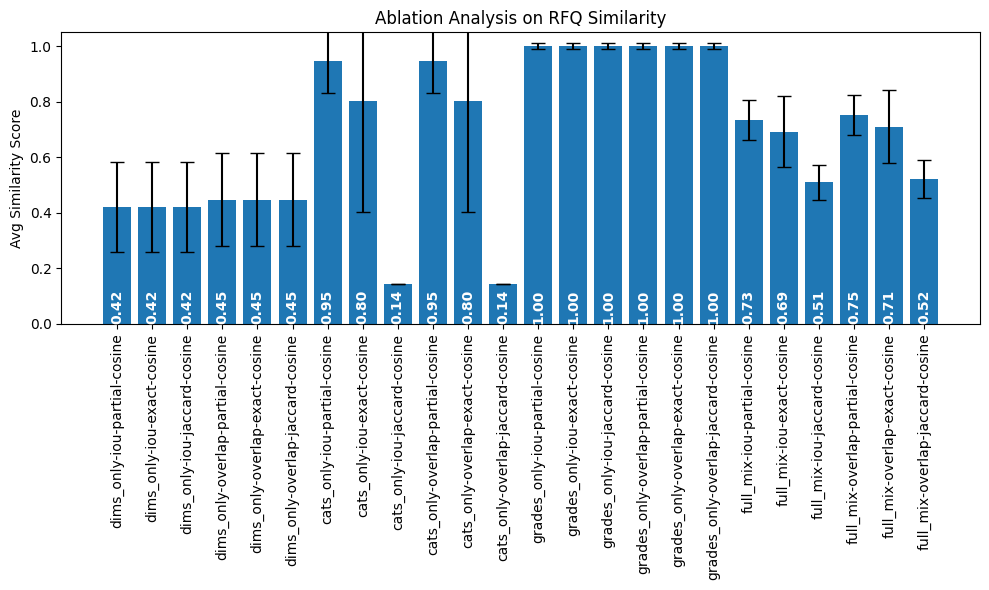

In [55]:
# Compute mean and std
avg_scores = {cfg: df["similarity_score"].mean() for cfg, df in results.items()}
std_scores = {cfg: df["similarity_score"].std() for cfg, df in results.items()}

plt.figure(figsize=(10, 6))
bars = plt.bar(avg_scores.keys(), avg_scores.values(), yerr=std_scores.values(), capsize=5)

# Add labels at the bottom of each bar
for bar, mean in zip(bars, avg_scores.values()):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # center of bar
        0.001,                               # small offset above 0
        f"{mean:.2f}",                       # formatted value
        ha="center", va="bottom",            # align center-bottom
        rotation=90, color="white", weight="bold"
    )

plt.xticks(range(len(avg_scores.keys())), avg_scores.keys(), rotation=90)
plt.ylabel("Avg Similarity Score")
plt.title("Ablation Analysis on RFQ Similarity")
plt.ylim(0, 1.05)  # optional: adjust top to leave space for error bars
plt.tight_layout()
plt.show()


Interpreting the results:

- Bars shorter than the majority => low average similarity => not good enough.
- Bars with long error bars that reach below the main cluster => unstable, less reliable.
- Bars with labels near the bottom or far from the cluster => visually confirm low performance.

In [56]:
threshold_mean = 0.70 # below this, experiment is underperforming
threshold_std = 0.05 # above this, experiment is unstable

not_good = [
    cfg for cfg, mean in avg_scores.items()
    if mean < threshold_mean or std_scores[cfg] > threshold_std
]

good_experiments = [
    cfg for cfg, mean in avg_scores.items()
    if mean >= threshold_mean and std_scores[cfg] >= threshold_std
]

print("Experiments not good enough:", not_good)
print()
print("Experiments that are potentially good:", good_experiments)

Experiments not good enough: ['dims_only-iou-partial-cosine', 'dims_only-iou-exact-cosine', 'dims_only-iou-jaccard-cosine', 'dims_only-overlap-partial-cosine', 'dims_only-overlap-exact-cosine', 'dims_only-overlap-jaccard-cosine', 'cats_only-iou-partial-cosine', 'cats_only-iou-exact-cosine', 'cats_only-iou-jaccard-cosine', 'cats_only-overlap-partial-cosine', 'cats_only-overlap-exact-cosine', 'cats_only-overlap-jaccard-cosine', 'full_mix-iou-partial-cosine', 'full_mix-iou-exact-cosine', 'full_mix-iou-jaccard-cosine', 'full_mix-overlap-partial-cosine', 'full_mix-overlap-exact-cosine', 'full_mix-overlap-jaccard-cosine']

Experiments that are potentially good: ['cats_only-iou-partial-cosine', 'cats_only-iou-exact-cosine', 'cats_only-overlap-partial-cosine', 'cats_only-overlap-exact-cosine', 'full_mix-iou-partial-cosine', 'full_mix-overlap-partial-cosine', 'full_mix-overlap-exact-cosine']


# Investigating overlap between results

In [57]:
def compare_top3_overlap(res1, res2):
    merged = res1.merge(res2, on="rfq_id", suffixes=("_1", "_2"))
    overlaps = merged.apply(
        lambda row: len(set([row.match_id_1]) & set([row.match_id_2])), axis=1
    )
    return overlaps.mean()


keys = list(results.keys())

# Create empty matrix
overlap_matrix = pd.DataFrame(
    np.zeros((len(keys), len(keys))),
    index=keys,
    columns=keys
)

# Fill matrix with overlaps
for i, k1 in enumerate(keys):
    for j, k2 in enumerate(keys):
        if i <= j:  # upper triangle (matrix is symmetric)
            overlap_matrix.loc[k1, k2] = compare_top3_overlap(results[k1], results[k2])
            overlap_matrix.loc[k2, k1] = overlap_matrix.loc[k1, k2]

- Blocks of darker cells => groups of methods that behave similarly (clusters).
- Rows/columns that are dark everywhere => a method that agrees with many others (a “consensus” approach).
- Rows/columns that are light compared to others => a method that behaves differently, producing distinct recommendations.

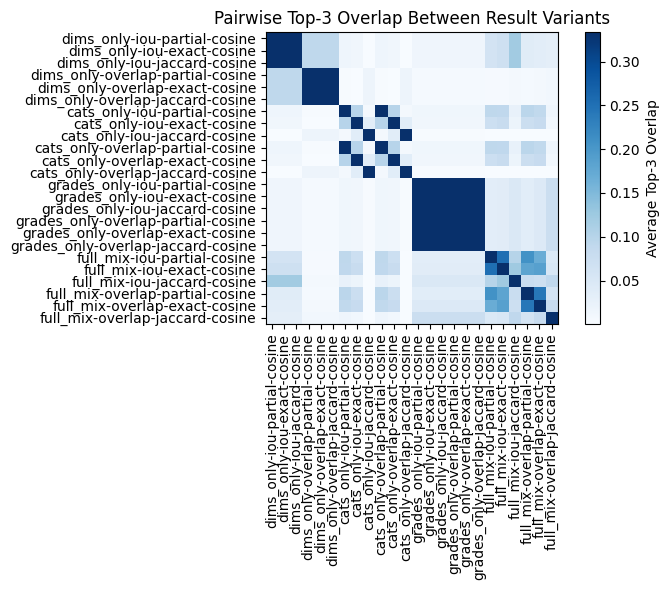

In [58]:
plt.figure(figsize=(8, 6))
plt.imshow(overlap_matrix, cmap="Blues", interpolation="nearest")
plt.colorbar(label="Average Top-3 Overlap")
plt.xticks(range(len(keys)), keys, rotation=90)
plt.yticks(range(len(keys)), keys)
plt.title("Pairwise Top-3 Overlap Between Result Variants")
plt.tight_layout()
plt.show()

We can sort the overlapping method to find about the methods that agrees the most with others:

In [59]:
# No need to exclude diagonal (self-overlap = 0.0)
avg_overlap = overlap_matrix.mean(axis=1)

# Sort from most to least consensus-like
avg_overlap = avg_overlap.sort_values(ascending=False)

print("Average overlap per method:")
print(avg_overlap * 100)

Average overlap per method:
grades_only-iou-partial-cosine        9.970370
grades_only-iou-exact-cosine          9.970370
grades_only-overlap-exact-cosine      9.970370
grades_only-overlap-jaccard-cosine    9.970370
grades_only-iou-jaccard-cosine        9.970370
grades_only-overlap-partial-cosine    9.970370
full_mix-iou-exact-cosine             7.984259
full_mix-iou-partial-cosine           7.672685
full_mix-overlap-exact-cosine         7.581944
full_mix-overlap-partial-cosine       7.476389
dims_only-iou-exact-cosine            7.397222
dims_only-iou-partial-cosine          7.397222
dims_only-iou-jaccard-cosine          7.397222
full_mix-iou-jaccard-cosine           6.529630
cats_only-iou-partial-cosine          5.905556
cats_only-overlap-partial-cosine      5.905556
cats_only-overlap-exact-cosine        5.773611
cats_only-iou-exact-cosine            5.773611
dims_only-overlap-partial-cosine      5.755556
dims_only-overlap-jaccard-cosine      5.755556
dims_only-overlap-exact-cosine  

# Using spearman

Ignoring this part as it takes a lot of time to run.

In [60]:
def compare_topk_spearman(res1, res2, k=3):

    # Ensure same RFQs
    rfqs = set(res1["rfq_id"]).intersection(res2["rfq_id"])
    correlations = []
    
    for rfq in rfqs:
        r1 = res1[res1["rfq_id"] == rfq].head(k).reset_index(drop=True)
        r2 = res2[res2["rfq_id"] == rfq].head(k).reset_index(drop=True)

        # Align by match_id (union of items in both lists)
        all_matches = list(set(r1["match_id"]).union(set(r2["match_id"])))
        
        # Build rank vectors
        ranks1 = []
        ranks2 = []
        for m in all_matches:
            # If missing, assign rank = k+1 (as if ranked after top-k)
            rank1 = r1.index[r1["match_id"] == m].tolist()
            rank2 = r2.index[r2["match_id"] == m].tolist()
            ranks1.append(rank1[0] + 1 if rank1 else k + 1)
            ranks2.append(rank2[0] + 1 if rank2 else k + 1)
        
        # Compute Spearman correlation
        rho, _ = spearmanr(ranks1, ranks2)
        if not np.isnan(rho):
            correlations.append(rho)
    
    return np.mean(correlations) if correlations else 0.0

In [61]:
# rho = compare_topk_spearman(
#     results["full_mix-iou-partial-cosine"],
#     results["cats+grades-iou-exact-cosine"],
#     k=3
# )

In [62]:
# keys = list(results.keys())

# # Create empty Spearman correlation matrix
# spearman_matrix = pd.DataFrame(
#     np.zeros((len(keys), len(keys))),
#     index=keys,
#     columns=keys
# )

# # Fill matrix with Spearman results
# for i, k1 in enumerate(keys):
#     for j, k2 in enumerate(keys):
#         if i <= j:  # upper triangle
#             rho = compare_topk_spearman(results[k1], results[k2], k=3)
#             print(f"Comparing {k1},{k2}: Spearmen rho={rho}")
#             spearman_matrix.loc[k1, k2] = rho
#             spearman_matrix.loc[k2, k1] = rho  # symmetric

In [63]:
# most_similar = spearman_matrix.stack().idxmax()
# least_similar = spearman_matrix.stack().idxmin()

# Cluster

In [64]:
df = merge_df.copy()

In [65]:
# Select features
categorical = ["grade", "coating", "finish", "form"]

numeric = ["thickness_min", "thickness_max", "width_min", "width_max", "length_min", "height_min", "weight_min", "weight_max", 
           "yield_strength_min", "yield_strength_max", "tensile_strength_min", "tensile_strength_max", "elongation_min", "elongation_max",
           "carbon_min", "carbon_max", "manganese_min", "manganese_max",
           "silicon_min", "silicon_max", "sulfur_min", "sulfur_max",
           "phosphorus_min", "phosphorus_max", "aluminum_min", "aluminum_max"
]

# Preprocessing & Clustering
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical)
])

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("cluster", kmeans)
])

df["cluster"] = pipeline.fit_predict(df)

Cluster Interpretations:
Cluster 0: S235JR COILS (UNKNOWN, UNKNOWN) ~4.6mm thick, elongation ~22% (Avg similarity: 0.61)
Cluster 1: DX51D COILS (HOT-DIP GALVANIZED (+Z/+GI), UNKNOWN) ~1.5mm thick, elongation ~28% (Avg similarity: 0.56)
Cluster 2: 16MNCRS5 ROUND BARS (AS ROLLED (+AR), UNKNOWN) ~35.5mm thick, elongation ~9% (Avg similarity: 0.65)
Cluster 3: UNKNOWN COILS (UNKNOWN, UNKNOWN) ~1.7mm thick, elongation ~0% (Avg similarity: 0.67)


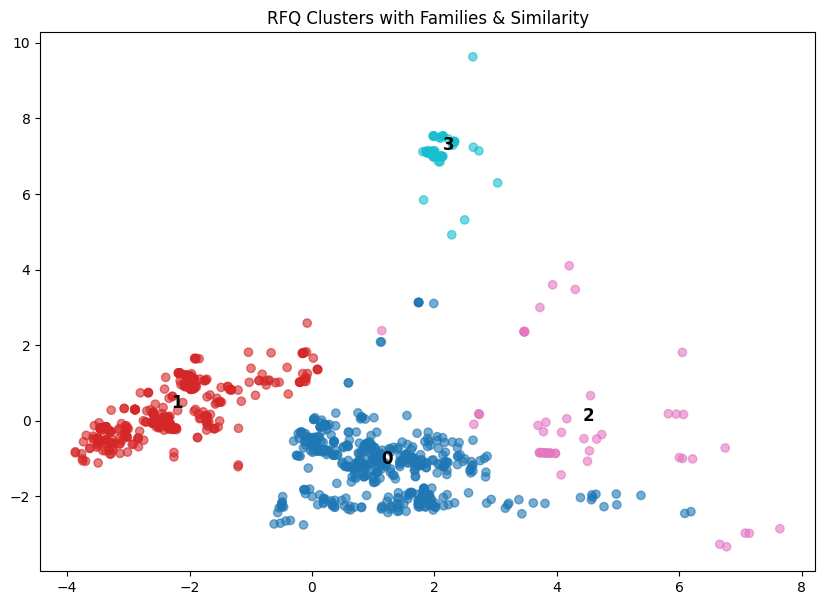

In [66]:
# Compute similarity score for each RFQ in its cluster 
aggregate_sims = aggregate_sim_score(df)

similarity_scores = []
for i, row in df.iterrows():
    cluster_idx = df[df["cluster"] == row["cluster"]].index
    # Average similarity to all other RFQs in the same cluster
    score = aggregate_sims[i, cluster_idx].mean()
    similarity_scores.append(score)

df["cluster_similarity"] = similarity_scores

# Generate cluster summaries 
cluster_labels = {}
for c in sorted(df["cluster"].unique()):
    cluster_data = df[df["cluster"] == c]
    
    # Most common categorical values
    common_values = {col: cluster_data[col].mode()[0] for col in categorical}
    
    # Average numeric values
    avg_values = {col: cluster_data[col].mean() for col in numeric}
    
    # Build short description
    description = (
        f"{common_values['grade']} {common_values['form']} "
        f"({common_values['finish']}, {common_values['coating']}) "
        f"~{avg_values['thickness_min']:.1f}mm thick, "
        f"elongation ~{avg_values['elongation_min']:.0f}%"
    )
    cluster_labels[c] = description

df["cluster_label"] = df["cluster"].map(cluster_labels)

# Print cluster interpretations & similarity stats
print("Cluster Interpretations:")
for c in sorted(df["cluster"].unique()):
    cluster_data = df[df["cluster"] == c]
    avg_sim = cluster_data["cluster_similarity"].mean()
    print(f"Cluster {c}: {cluster_labels[c]} (Avg similarity: {avg_sim:.2f})")

# Optional visualization 

X_processed = preprocessor.fit_transform(df)
X_reduced = PCA(n_components=2).fit_transform(X_processed.toarray())
plt.figure(figsize=(10,7))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df["cluster"], cmap="tab10", alpha=0.6)
for c in cluster_labels.keys():
    x_mean = X_reduced[df["cluster"] == c, 0].mean()
    y_mean = X_reduced[df["cluster"] == c, 1].mean()
    plt.text(x_mean, y_mean, f"{c}", fontsize=12, weight="bold")
plt.title("RFQ Clusters with Families & Similarity")
# plt.savefig("../docs/cluster.png")
plt.show()